In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Colab Notebooks/Flickr8k_Dataset.zip"

In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [0]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

filename = "Flickr8k.token.txt"
#load description
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
    # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))


Loaded: 8092 


In [0]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [0]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
# prepare translation table for removing punctuation
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
def to_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [0]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line.split('.')[0])
    return set(dataset)

filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
images

'Flicker8k_Dataset/'

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img:
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train imag
print(len(train_img))

6000


In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images


In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    #Xception model inputs 299*299*3 shaped images
    img = image.load_img(image_path, target_size = (299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)
    x = preprocess_input(x)
    return x

In [0]:
model = Xception(weights = 'imagenet',pooling = 'avg')

91889664/91884032 [==============================] - 2s 0us/step


In [0]:
model_new= Model(model.input, model.layers[-2].output)

In [0]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

dump(encoding_train, open("encoded_train_images.pkl","wb"))

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
    
dump(encoding_test, open("encoded_test_images.pkl","wb"))

print(len(train_img))

6000


In [0]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
train_features['1000268201_693b08cb0e.jpg'].shape

Photos: train=6000


(2048,)

In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    # loop for ever over images
    
    n=0
    # loop for ever over images
    while 1:
      for key, desc_list in descriptions.items():
        n+=1# retrieve the photo feature
        photo = photos[key+'.jpg']
        X1,X2,y = create_sequence(wordtoix, max_length, desc_list, photo)
        if n==num_photos_per_batch:
          yield [[array(X1), array(X2)], array(y)]

def create_sequence(wordtoix, max_length, desc_list, photo):
      X1, X2, y = list(), list(), list()
      for desc in desc_list:
          # encode the sequence
          seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
          # split one sequence into multiple X, y pairs
          for i in range(1, len(seq)):
              # split into input and output pair
              in_seq, out_seq = seq[:i], seq[i]
              # pad input sequence
              in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
              # encode output sequence
              out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
              # store
              X1.append(photo)
              X2.append(in_seq)
              y.append(out_seq)
            # yield the batch data
      return np.array(X1),np.array(X2),np.array(y)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      422912      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 10
steps = len(train_descriptions)

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
6000/6000 [==============================] - 1016s 169ms/step - loss: 3.3093
Epoch 1/1
6000/6000 [==============================] - 1044s 174ms/step - loss: 3.0987
Epoch 1/1
6000/6000 [==============================] - 1046s 174ms/step - loss: 2.9745
Epoch 1/1
6000/6000 [==============================] - 1067s 178ms/step - loss: 2.8922
Epoch 1/1
6000/6000 [==============================] - 1075s 179ms/step - loss: 2.8317
Epoch 1/1
6000/6000 [==============================] - 1029s 172ms/step - loss: 2.7880
Epoch 1/1
6000/6000 [==============================] - 1055s 176ms/step - loss: 2.7527
Epoch 1/1
6000/6000 [==============================] - 1038s 173ms/step - loss: 2.7264
Epoch 1/1
6000/6000 [==============================] - 1023s 170ms/step - loss: 2.7033
Epoch 1/1
6000/6000 [==============================] - 1039s 173ms/step - loss: 2.6850


In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
6000/6000 [==============================] - 1034s 172ms/step - loss: 2.6560
Epoch 1/1
6000/6000 [==============================] - 1066s 178ms/step - loss: 2.6514
Epoch 1/1
6000/6000 [==============================] - 1085s 181ms/step - loss: 2.6404
Epoch 1/1
6000/6000 [==============================] - 990s 165ms/step - loss: 2.6341
Epoch 1/1
6000/6000 [==============================] - 1013s 169ms/step - loss: 2.6304
Epoch 1/1
6000/6000 [==============================] - 1037s 173ms/step - loss: 2.6276
Epoch 1/1
6000/6000 [==============================] - 1019s 170ms/step - loss: 2.6237
Epoch 1/1
6000/6000 [==============================] - 1035s 173ms/step - loss: 2.6190
Epoch 1/1
6000/6000 [==============================] - 1023s 170ms/step - loss: 2.6196
Epoch 1/1
6000/6000 [==============================] - 1067s 178ms/step - loss: 2.6171


In [0]:
model.load_weights('model_9.h5')


In [0]:
images = 'Flicker8k_Dataset/'

In [0]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


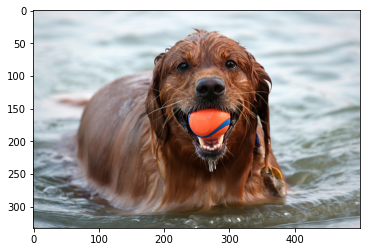

Greedy: dog is running through the water


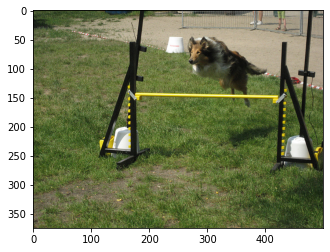

Greedy: dog is jumping over hurdle


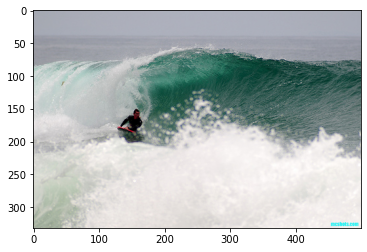

Greedy: man in wetsuit is surfing on the water


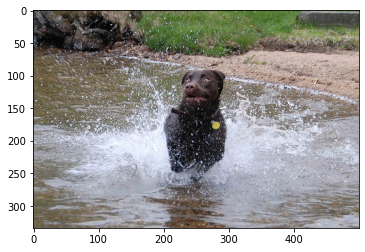

Greedy: dog is running through the water


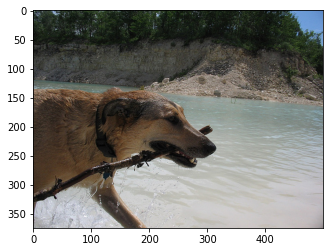

Greedy: dog is running through the water


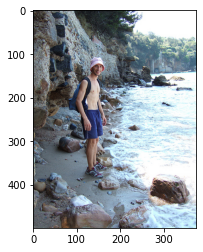

Greedy: man in red shorts is standing on the edge of rock overlooking the water


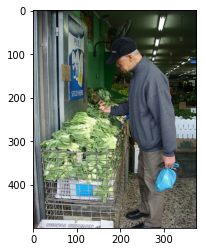

Greedy: man in red shirt is standing outside store


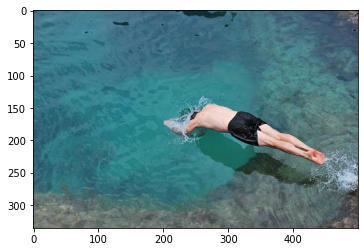

Greedy: man in black wetsuit is jumping into the water


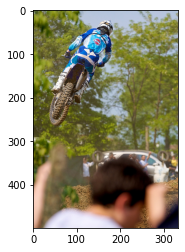

Greedy: man on bike is turning on the side of road


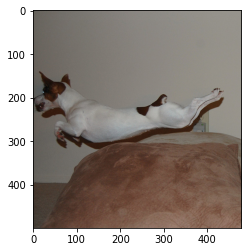

Greedy: white dog is running through the grass


In [0]:
for i in range(10):
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))